In [1]:
import csv
import multiprocessing
import os
import random
import shutil
import time
import math

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from solver.simulated_annealing import SimulatedAnnealing
from solver.max_weighted_cnf import MaxWeightedCNF
from solver.optimum import Optimum

In [3]:
DATA_SUITES = (
    'wuf20-71',
    'wuf20-71R',
    'wuf20-91',
    'wuf20-91R',
    'wuf50-200',
    'wuf50-218',
    'wuf50-218R',
    'wuf75-325',
    'wuf100-430',
)

DATA_SUITES_VARIATIONS = (
    'M',
    'N',
    'Q',
    'R',
)

In [4]:
DATA_DIRECTORY = 'data'
OUTPUT_DIRECTORY = 'output'
BACKUP_DIRECTORY = 'backup'

In [5]:
# RUNS = 1
#
# def flatten(list):
#     return [item for sublist in list for item in sublist]
#
# if not os.path.exists(BACKUP_DIRECTORY):
#     os.mkdir(BACKUP_DIRECTORY)
# BACKUP_TIMESTAMP = time.time().__str__()
#
# if os.path.exists(OUTPUT_DIRECTORY):
#     shutil.copytree(OUTPUT_DIRECTORY, os.path.join(BACKUP_DIRECTORY, BACKUP_TIMESTAMP))
#     shutil.rmtree(OUTPUT_DIRECTORY)
# os.mkdir(OUTPUT_DIRECTORY)
#
# for suite in DATA_SUITES:
#     os.mkdir(os.path.join(OUTPUT_DIRECTORY, suite))
#
#     for suite_variation in DATA_SUITES_VARIATIONS:
#         print(suite, suite_variation)
#
#         os.mkdir(os.path.join(OUTPUT_DIRECTORY, suite, suite_variation))
#         sa_output = open(os.path.join(OUTPUT_DIRECTORY, suite, suite_variation, 'sa.csv'), 'w')
#
#         sa_heading = ['instance', 'weight', 'satisfied_clauses', 'clauses',
#                       'true_variables', 'variables', 'current_objective_history', 'best_objective_history']
#         sa_writer = csv.writer(sa_output)
#
#         sa_writer.writerow(sa_heading)
#
#         optimum = None
#         optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
#
#         if os.path.exists(optimum_path):
#             optimum = Optimum(optimum_path)
#
#         for root, _, files in os.walk(os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}')):
#             sas = flatten([
#                 [
#                     SimulatedAnnealing(
#                         MaxWeightedCNF(os.path.join(root, file))
#                     )
#                 ] * RUNS for file in files
#             ])
#
#             pool = multiprocessing.Pool(processes=8)
#
#             sa_results = list(tqdm(pool.imap(run_simulated_annealing, sas), total=len(sas)))
#
#             sa_results = [(result[0].split('/')[-1],
#                            result[1], result[2], result[3], result[4],
#                            result[5], result[6], result[7]) for result in sa_results]
#
#             sa_results.sort(key=lambda result: result[0])
#
#             sa_writer.writerows(sa_results)

In [6]:
def run_simulation(suite, suite_variation, instance, initial_temperature):
    _, weight, satisfied_clauses, clauses, true_variables, variables, current_objective_history, best_objective_history =\
        SimulatedAnnealing(
            MaxWeightedCNF(os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}', instance)),
            initial_temperature=initial_temperature
        ).run(record_history=True)

    optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
    optimum = Optimum(optimum_path)

    optimal_weight = optimum.optimal_weight(instance[1:].rstrip('.mwcnf'))

    return optimal_weight, current_objective_history, best_objective_history

In [23]:
def run_experiment_initial_temperature(suite, suite_variation, instance, initial_temperatures=(5000, 2500, 1000, 500)):
    fig, axes = plt.subplots(math.ceil(len(initial_temperatures) / 2), 2, figsize=(20, 20))

    if len(initial_temperatures) % 2 != 0:
      for l in axes[int(len(initial_temperatures) / 2 - 1), 1].get_xaxis().get_majorticklabels():
          l.set_visible(True)
      fig.delaxes(axes[int(len(initial_temperatures) / 2), 1])

    for i, initial_temperature in enumerate(initial_temperatures):
        optimal_weight, current_objective_history, best_objective_history = run_simulation(
            suite, suite_variation, instance, initial_temperature
        )
        optimal_weight_history = [optimal_weight] * len(current_objective_history)

        ax = axes[int(i / 2), i % 2]

        sns.lineplot(data=current_objective_history, label='Current', ax=ax)
        sns.lineplot(data=best_objective_history, label='Best', ax=ax)
        sns.lineplot(data=optimal_weight_history, label='Optimal', ax=ax)

        ax.set_title(f'initial temperature: {initial_temperature}')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Weight')
        ax.legend()

    fig.suptitle(f'Initial temperature experiment\n{suite}-{suite_variation}/{instance}', fontsize=30)
    #fig.tight_layout(pad=5, rect=[0, 0.03, 1, 0.95])

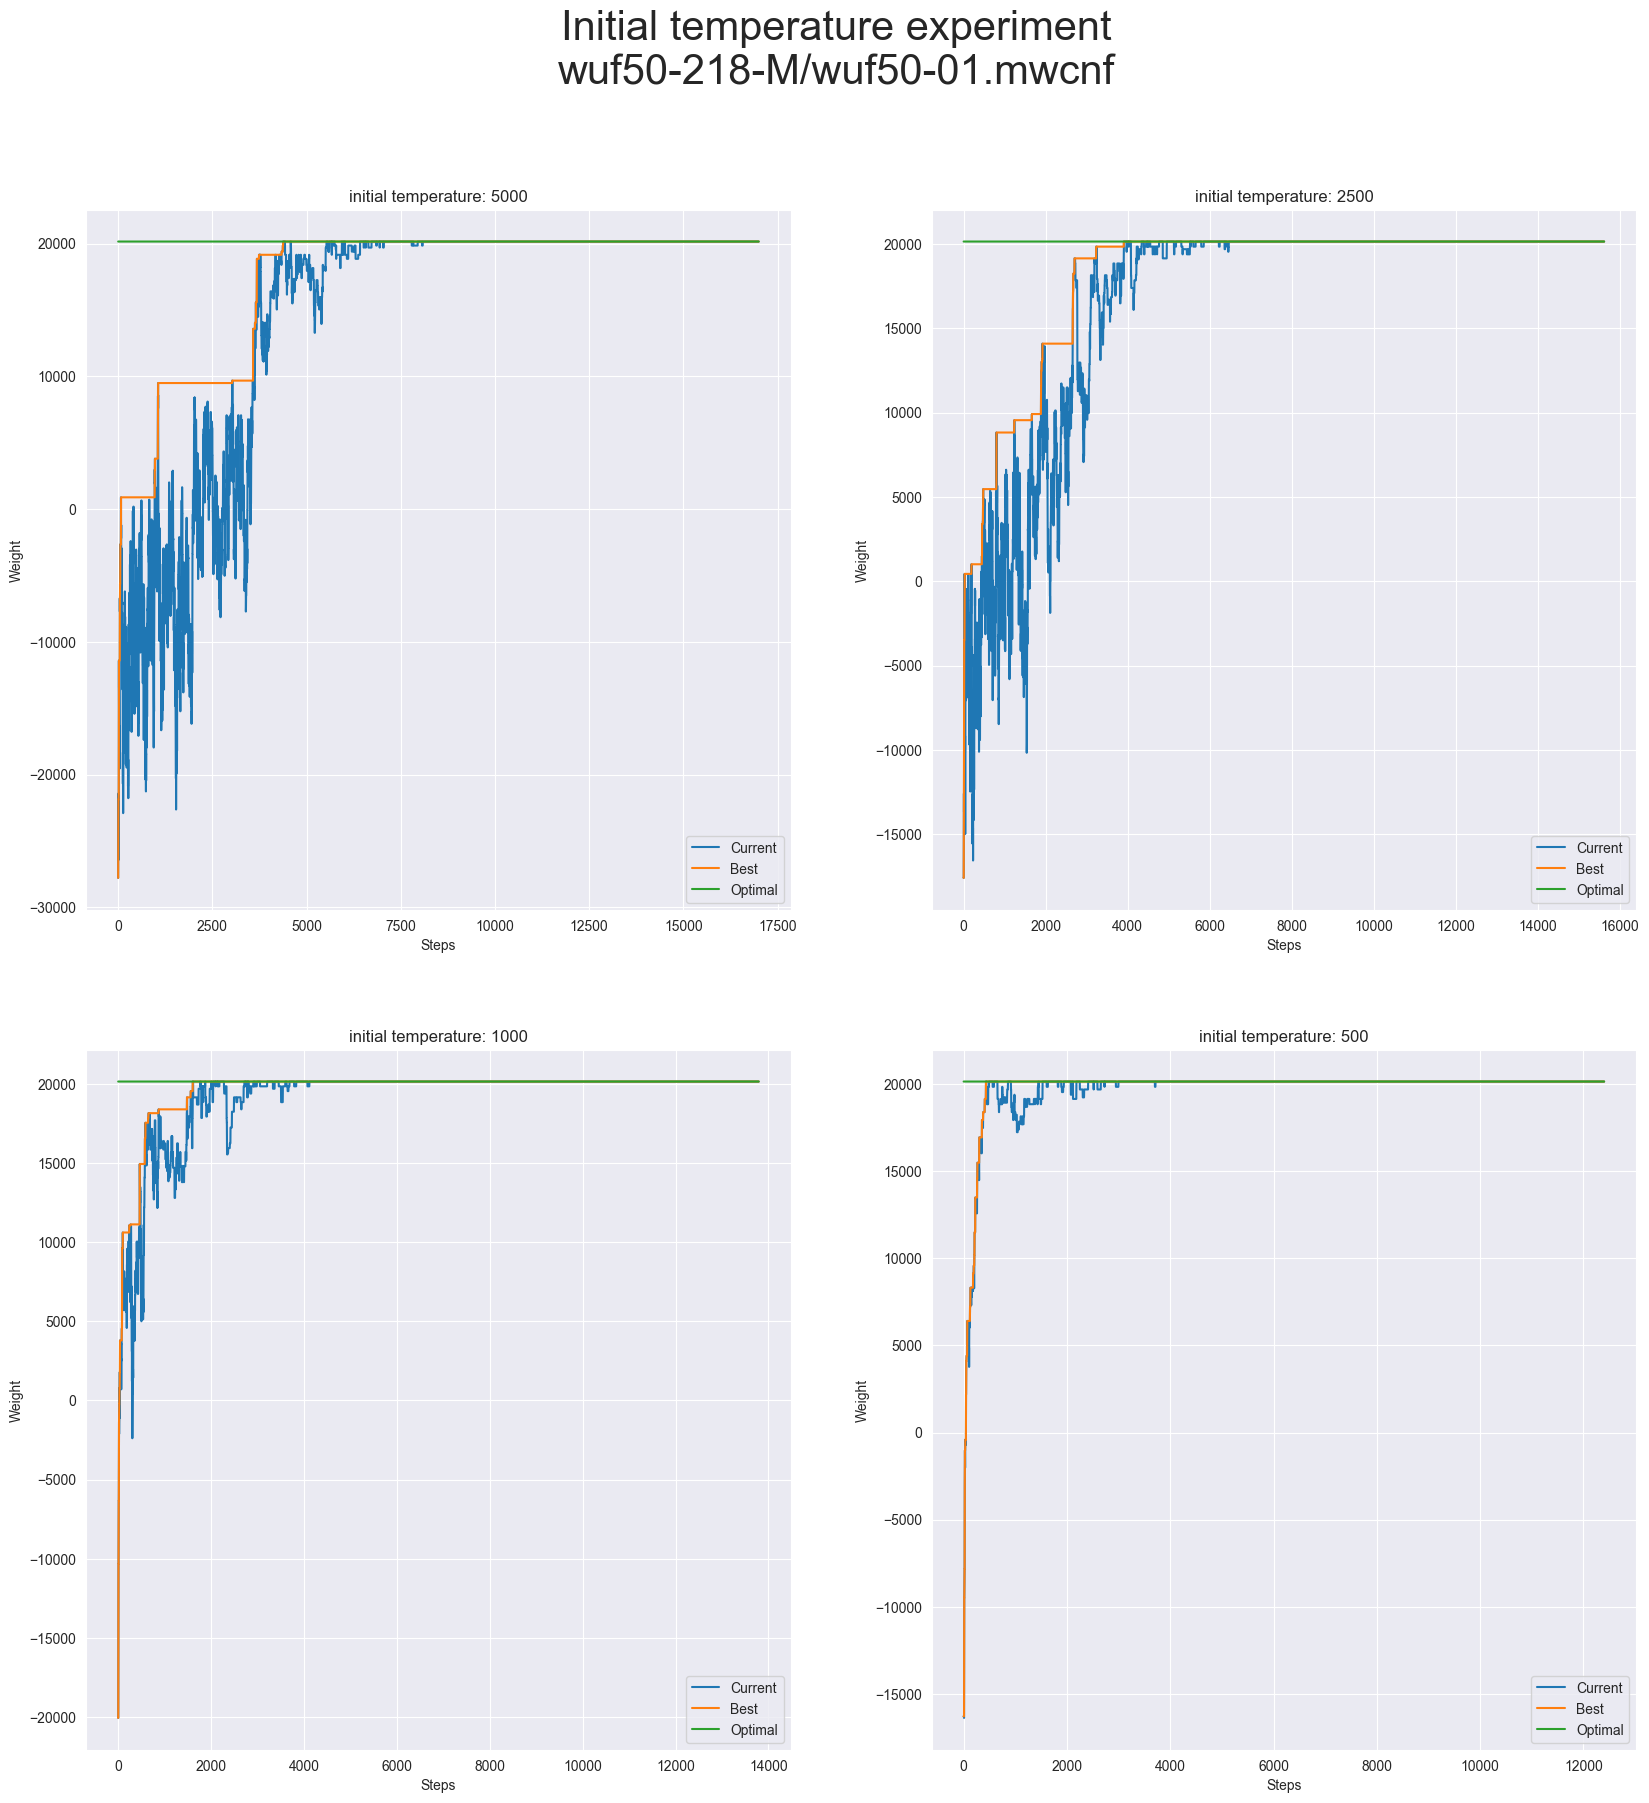

In [24]:
suite = 'wuf50-218'
suite_variation = 'M'
instance = 'wuf50-01.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)